In [92]:
from os import makedirs, scandir
from os.path import exists, join

import numpy as np
import pandas as pd

from cv2 import cvtColor, COLOR_BGR2RGB, imread, imwrite, resize
from rich.progress import track, Progress

from utils.utils import (get_dummy_labels, read_csv, get_unique_patients, plot_age_distribution, plot_disease_distribution, random_fl_split, stratified_train_test_split)

In [137]:
# f_path = "../dataset/Data_entry_2017_filtered_single_label.csv"
f_path = "../dataset/splits/fl_splits/balanced/2_clients/data_entry_2017_val_0.csv"

data_df = read_csv(f_path)

data_df.drop(columns=["Unnamed: 0"], inplace=True)
data_df.head()

,Unnamed: 0.1,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImagePixelSpacing[x,y],...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,00000005_000.png,No Finding,0,5,69,F,PA,0.168,0.168,...,0,0,0,0,0,1,0,0,0,0
1,1,00000005_001.png,No Finding,1,5,69,F,AP,0.168,0.168,...,0,0,0,0,0,1,0,0,0,0
2,2,00000005_002.png,No Finding,2,5,69,F,AP,0.168,0.168,...,0,0,0,0,0,1,0,0,0,0
3,3,00000005_003.png,No Finding,3,5,69,F,PA,0.143,0.143,...,0,0,0,0,0,1,0,0,0,0
4,4,00000005_004.png,No Finding,4,5,70,F,PA,0.143,0.143,...,0,0,0,0,0,1,0,0,0,0


In [138]:
# ds_path = "../dataset/resized/"
# # Get Path with nan values
# nan_path = data_df[data_df["Path"].isnull()]["Image Index"].values
# len(nan_path)

# dirs = {}
# for _dirs in scandir(ds_path):
#     if _dirs.is_dir():
#         # print(_dirs.path)
#         _d = join(_dirs.path, "images")
#         if exists(_d):
#             dirs[_d] = [_f.name for _f in scandir(_d) if _f.is_file() and _f.name.endswith(".png")]

In [139]:
# columns = data_df.columns
# to_drop = ["Unnamed: 0", "OriginalImage[Width", "Height]", "OriginalImagePixelSpacing[x", "y]", "Unnamed: 11"]
# data_df.drop(columns=to_drop, inplace=True, errors="ignore")

In [140]:
# new_df = pd.DataFrame(columns=columns)

# for _dirs in dirs:
#     _df = data_df[data_df["Image Index"].isin(dirs[_dirs])]
#     new_df = pd.concat([new_df, _df], ignore_index=True)
#     new_df["Path"] = new_df["Path"].str.replace("extracted", "resized")

# # Drop columns in new_df
# # new_df = new_df.drop(columns=["Unnamed: 0", "OriginalImage[Width", "Height]",
# #                               "OriginalImagePixelSpacing[x", "y]",
# #                               "Unnamed: 11"])
# new_df = new_df.drop(columns=to_drop, errors="ignore")

In [141]:
# new_df = get_dummy_labels(new_df)

In [142]:
# new_df

In [143]:
# # Concatenate Path with Image Index
# _paths = data_df["Path"].str.cat(data_df["Image Index"], sep="/")
# # Replace resized with extracted
# _paths = _paths.str.replace("resized", "extracted")

In [144]:
# _paths

In [146]:
# def get_images_to_process(data_df: pd.DataFrame, path:str) -> list:
#     """Get images to process from the dataset.
#     If the image is not found in the indicated path, it will be added to the list of images to process.

#     Args:
#         data_df (pd.DataFrame): Dataframe containing the data.
#         path (str): Path to the images.

#     Returns:
#         list: List of images to process.
#     """
#     # If path does not exist, create it
#     if not exists(path):
#         makedirs(path)
#         return data_df["Path"].str.contains(path).cat(data_df["Image Index"], sep="/").tolist()
#     return [f for f in data_df["Path"].str.cat(data_df["Image Index"], sep="/").tolist() if not exists(join(path, f))]

def get_images_to_process(data_df: pd.DataFrame, path: str, to_replace: list = ["", ""]) -> list:
    """
    Get images to process from the dataset.
    If the image is not found in the indicated path, it will be added to the list of images to process.

    Args:
        data_df (pd.DataFrame): Dataframe containing the data.
        path (str): Path to the images.

    Returns:
        list: List of images to process.
    """
    # Ensure the directory exists
    save_dir = path.replace(to_replace[0], to_replace[1])
    if not exists(save_dir):
        makedirs(save_dir)
        return data_df[data_df["Path"].str.contains(path)]["Image Index"].tolist()
    
    images = [f.name for f in scandir(save_dir) if f.is_file() and f.name.endswith(".png")]
    # return [f for f in data_df["Path"].str.cat(data_df["Image Index"], sep="/").tolist() if f not in images]
    return [f for f in data_df[data_df["Path"].str.contains(path)]["Image Index"].tolist() if f not in images]

In [147]:
df_paths = data_df["Path"].unique()

to_process = {
    _path: [
        _f for _f in get_images_to_process(data_df, _path, to_replace=["extracted", "resized"])
    ]
    for _path in track(df_paths, description="Processing Paths")
}

total = sum([len(to_process[_path]) for _path in to_process])
print(f"Total images to process: {total}")

Output()

Total images to process: 0


In [103]:
def resize_images(to_process: dict, to_replace: list = ["", ""], size: tuple = (224, 224)) -> None:
    """Resize images to a fixed size.

    Args:
        to_process (dict): Dictionary containing the paths and images to process.
        to_replace (list, optional): List of strings to replace in the path. Defaults to ["", ""].
        size (tuple, optional): Size to resize the images. Defaults to (224, 224).
    """
    with Progress() as progress:
        dir_task = progress.add_task("Creating Directories", total=len(to_process))
        for _path in to_process:
            f_task = progress.add_task(f"Processing {_path}", total=len(to_process[_path]))
            save_dir = _path.replace(to_replace[0], to_replace[1])
            for _f in to_process[_path]:
                img = imread(join(_path, _f))
                img = cvtColor(img, COLOR_BGR2RGB)
                img = resize(img, size)
                imwrite(join(save_dir, _f), img)
                progress.update(f_task, advance=1)
            progress.remove_task(f_task)
            progress.update(dir_task, advance=1)

resize_images(to_process, to_replace=["extracted", "resized"], size=(224, 224))

Output()

In [ ]:
# # save_dir = "../dataset/resized/"

# # Resize all images to 224*224
# # for path in paths:
# for path in track(paths):
#     # save_path = path.replace("dataset/extracted", "dataset/resized")
#     p = path.replace("dataset/extracted", "dataset/resized").split("/")
#     img_name = p[-1]
#     save_path = "/".join(p[:-1])
#     if not exists(save_path):
#         makedirs(save_path)
#     img = imread(path)
#     img = resize(img, (224, 224))
#     save_name = f"{save_path}/{img_name}"
#     if not exists(save_name):
#         # print(f"Saving {save_name}")
#         imwrite(f"{save_path}/{img_name}", img)

In [ ]:
# # Save new_df
# new_df.to_csv("../dataset/splits/data_entry_2017_test.csv", index=False)

In [ ]:
_, val_data = stratified_train_test_split(new_df)

_ = plot_age_distribution(val_data, plot_title="Gender distribution by age (Train set)")

In [ ]:
# # Save new_df to csv
# val_data.to_csv("../Data_entry_2017_filtered_single_label.csv", index=False)

In [ ]:
data_df["Path"]

In [ ]:
def get_paths(df):
    return df["Path"].str.cat(df["Image Index"], sep="/")

paths = get_paths(data_df)

In [ ]:
# save_dir = "../dataset/resized/"

# Resize all images to 224*224
# for path in paths:
for path in track(paths):
    # save_path = path.replace("dataset/extracted", "dataset/resized")
    p = path.replace("dataset/extracted", "dataset/resized").split("/")
    img_name = p[-1]
    save_path = "/".join(p[:-1])
    if not exists(save_path):
        makedirs(save_path)
    img = imread(path)
    img = resize(img, (224, 224))
    save_name = f"{save_path}/{img_name}"
    if not exists(save_name):
        print(f"Saving {save_name}")
        # imwrite(f"{save_path}/{img_name}", img)

In [26]:
train_df, val_df = stratified_train_test_split(data_df)

/home/irina/miniconda3/envs/viz_tools/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
_ = plot_age_distribution(train_df, plot_title="Gender distribution by age (Train set)")

In [ ]:
_ = plot_age_distribution(val_df, plot_title="Gender distribution by age (Validation set)")

In [ ]:
plot_disease_distribution(train_df)

In [ ]:
plot_disease_distribution(val_df)

In [ ]:
# from typing import Tuple, Union

# import numpy as np
# import pandas as pd

# def rd_fl_split(
#     n_splits: int,
#     df: pd.DataFrame,
#     unbalanced: bool = False,
#     extreme: bool = False,
#     target_clients: Union[int, float] = 0,
# ) -> Tuple[pd.DataFrame]:
#     """Split the dataset into n_splits clients using random assignment with optional extreme unbalancing and reassignment of excluded patients.

#     Args:
#     -----
#         n_splits (int): Number of clients to split the data into.
#         df (pd.DataFrame): DataFrame containing the data.
#         unbalanced (bool): Whether to split the data into unbalanced clients.
#         extreme (bool): Whether to apply extreme unbalancing.
#         target_clients (Union[int, float]): Number or percentage (if float) of clients
#                                              to be subjected to extreme unbalancing.

#     Returns:
#     --------
#         Tuple[pd.DataFrame]: Tuple containing the DataFrames for each client.
#     """
#     patients = df["Patient ID"].unique()
#     np.random.shuffle(patients)
    
#     assert target_clients < n_splits, "Number of target clients cannot exceed the number of splits."
#     assert target_clients > 0, "Number of target clients must be greater than 0."
#     assert n_splits < len(patients), "Number of splits cannot exceed the number of unique patients."

#     if unbalanced:
#         random_points = np.sort(
#             np.random.choice(range(1, len(patients)), n_splits - 1, replace=False)
#         )
#         split_sizes = np.diff([0] + random_points.tolist() + [len(patients)])
#     else:
#         base_size = len(patients) // n_splits
#         split_sizes = np.array([base_size] * n_splits)
#         remainder = len(patients) % n_splits
#         if remainder > 0:
#             indices = np.random.choice(range(n_splits), size=remainder, replace=False)
#             split_sizes[indices] += 1

#     split_points = np.cumsum(split_sizes)[:-1]
#     clients = np.split(patients, split_points)
#     print(clients)

#     if extreme:
#         # Determine the clients to apply extreme unbalancing to
#         target_clients_count = target_clients
#         if isinstance(target_clients, float):  # If it's a percentage
#             target_clients_count = max(1, int(n_splits * target_clients))

#         # Special case: Ensure all clients are included if there are only 2 clients
#         if n_splits == 2:
#             target_clients_count = n_splits

#         target_clients_indices = (
#             np.random.choice(range(n_splits), size=target_clients_count, replace=False)
#             if target_clients_count > 0
#             else []
#         )

#         unique_classes = df["Finding Labels"].str.split("|").explode().unique()
#         unique_classes = unique_classes[unique_classes != "No Finding"]
        
#         to_swap = np.array_split(np.random.permutation(unique_classes), target_clients_count)

#         # remaining_patients = {}
#         patients_to_swap = {}
#         for tc_idx in target_clients_indices:
#             # print(f"Excluding classes {to_swap[tc_idx]} from client {tc_idx}")
#             client_df = df[df["Patient ID"].isin(clients[tc_idx])]
#             # classes_to_exclude = to_swap.pop()
#             classes_to_exclude = to_swap[tc_idx]
#             excluded_patients = client_df[
#                 client_df["Finding Labels"].str.contains("|".join(classes_to_exclude))
#             ]["Patient ID"].unique()
#             # clients[tc_idx] = np.setdiff1d(clients[tc_idx], excluded_patients)
#             # remaining_patients = np.setdiff1d(patients, np.concatenate(clients))
#             patients_to_swap[tc_idx] = excluded_patients
#             clients[tc_idx] = np.setdiff1d(clients[tc_idx], excluded_patients)

#         # Shift idx of to_swap to avoid reassigning the same patients
#         clients = clients[::-1]
#         for idx in target_clients_indices:
#             clients[idx] = np.concatenate((clients[idx], patients_to_swap[idx]))

#     client_dfs = [
#         df[df["Patient ID"].isin(client)].reset_index(drop=True) for client in clients
#     ]

#     return tuple(client_dfs)

In [28]:
train_df = pd.read_csv("../dataset/splits/data_entry_2017_train.csv")
val_df = pd.read_csv("../dataset/splits/data_entry_2017_val.csv")

In [89]:
n_clients = 4
unbalanced = True
if unbalanced:
    s_dir = "unbalanced"
else:
    s_dir = "balanced"

fl_split_rd_train = random_fl_split(n_splits=n_clients, df=train_df, unbalanced=unbalanced, extreme=False, target_clients=0.5)
fl_split_rd_val = random_fl_split(n_splits=n_clients, df=val_df, unbalanced=unbalanced, extreme=False, target_clients=0.5)

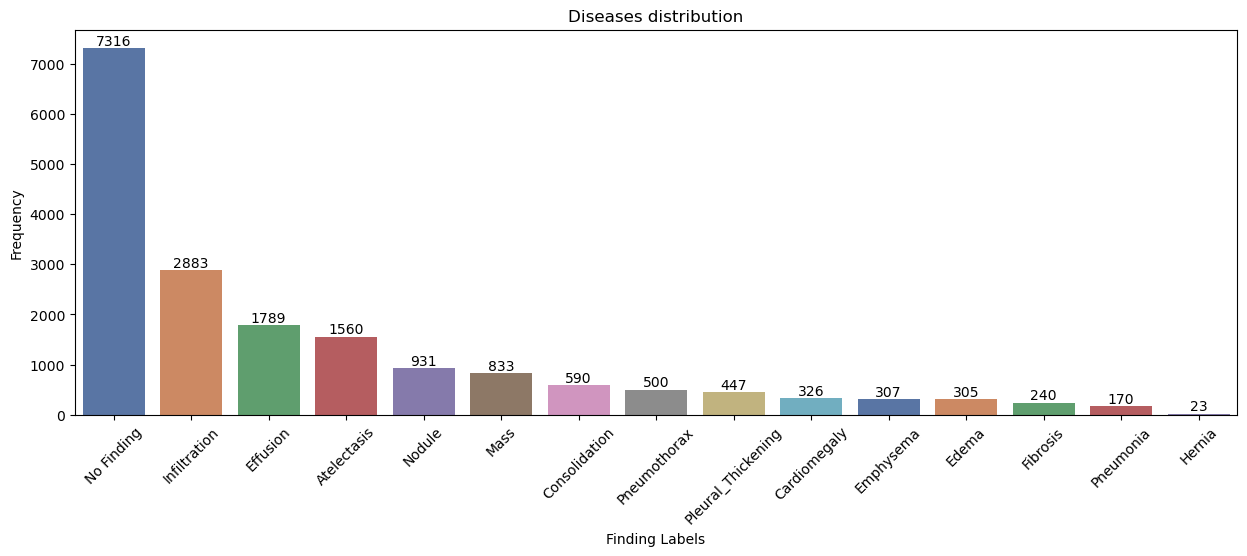

In [90]:
plot_disease_distribution(fl_split_rd_train[0])

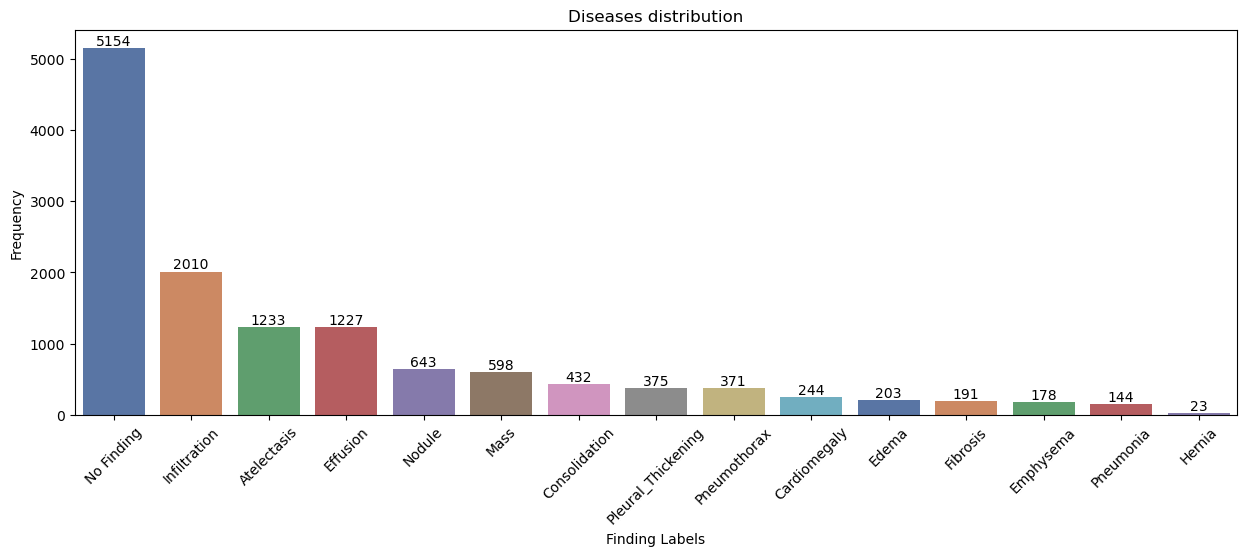

In [91]:
plot_disease_distribution(fl_split_rd_train[1])

In [86]:
# train_data.to_csv("../dataset/splits/data_entry_2017_train.csv")
save_dir = f"../dataset/splits/fl_splits/{s_dir}/{n_clients}_clients/"
if not exists(save_dir):
    makedirs(save_dir)

for idx, fl in enumerate(fl_split_rd_train):
    fl.to_csv(f"{save_dir}/data_entry_2017_train_{idx}.csv")

for idx, fl in enumerate(fl_split_rd_val):
    fl.to_csv(f"{save_dir}//data_entry_2017_val_{idx}.csv")

In [ ]:
from os import listdir

import pandas as pd

n_clients = 2

split_dir = f"../dataset/splits/fl_splits/{n_clients}_clients/"

for fl in listdir(split_dir):
    print(fl)
    df = pd.read_csv(split_dir + fl)
    # Print the number of unique patients in each client
    print(df["Image Index"].nunique())

In [ ]:
new_df

In [ ]:
original_csv = "../Data_Entry_2017.csv"

original_df = pd.read_csv(original_csv)
# Filter out the patients that are in new_df
original_df = original_df[original_df["Image Index"].isin(new_df["Image Index"])]
# Reset the index
original_df = original_df.reset_index(drop=True)

In [ ]:
# Compare the order of the patients in the original and new DataFrames
original_df["Finding Labels"].equals(new_df["Finding Labels"])

In [ ]:
original_df

In [ ]:
train_df_path = "../dataset/splits/data_entry_2017_val.csv"

train_df = pd.read_csv(train_df_path)
train_df

In [ ]:
train_df["Finding Labels"].value_counts()

In [ ]:
# Pick 200 patients from the training set
patients = train_df["Patient ID"].unique()
np.random.shuffle(patients)
patients = patients[:]

classes_to_keep = ["No Finding", "Infiltration", "Atelectasis", "Effusion", "Nodule"]
classes_to_exclude = [cl for cl in train_df["Finding Labels"].str.split("|").explode().unique() if cl not in classes_to_keep]

# Filter out the patients that are not in the selected patients
sampled_train_df = train_df[train_df["Patient ID"].isin(patients)]
# Filter out the classes that are not in classes_to_keep
sampled_train_df = sampled_train_df[sampled_train_df["Finding Labels"].str.contains("|".join(classes_to_keep))]
# Drop the class columns
sampled_train_df = sampled_train_df.drop(columns=classes_to_exclude)
sampled_train_df = sampled_train_df.reset_index(drop=True)

In [ ]:
sampled_train_df

In [ ]:
sampled_train_df.to_csv("../dataset/splits/data_entry_2017_val_sampled.csv", index=False)